# **Projet Pneumonie**

## **A - Analyse du dataset**

### ***1 - Répartition des classes***

On remarque qu’on est sur un dataset d'entraînement désequilibré, avec dans le dataset d’entraînement sur les 5216 images 74,3% de pneumonie (3875 images) pour 25,7% de normal (1341 images * 100 / 5216). Pour éviter que la majorité de pneumonie biaise le model, on va donc :
- éviter d'utiliser l'accuracy comme metric et préférer F1-score et ROC-AUC
- éventuellement faire du rééchantillonnage pour voir si cela permet d'améliorer les résultats (undersampling de PNEUMONIA ou oversampling de NORMAL)

On remarque aussi que le dossier pneumonie contient deux types d'images, les pneumonies d'origine virale et les pneumonies d'origine bactérienne.

Analysons la répartition

In [86]:
import os

def analyse_pneumonia_files(dir):
    virus_count = 0
    bacteria_count = 0
    pneumonia_dir = os.path.join(dir, "PNEUMONIA")

    for img_name in os.listdir(pneumonia_dir):
        if (
            img_name.startswith(".") or "Zone.Identifier" in img_name
        ):  # Présence de Zone.Identifier dans les fichiers téléchargés sur Windows, il faut les ignorer sinon on a 2 fois le nombre réel d'images
            continue

        if img_name.__contains__("virus"): 
            # print(f"Image virus: {img_name}")
            virus_count += 1
        elif img_name.__contains__("bacteria"):
            # print(f"Image bacteria: {img_name}")
            bacteria_count += 1
            
    return virus_count, bacteria_count


In [87]:
base_dir = "./data/chest_Xray"
result = analyse_pneumonia_files(os.path.join(base_dir, "val"))
virus, bacteria = result
result  # (virus : 0, bacteria : 8)

(0, 8)

In [90]:
base_dir = "./data/chest_Xray"
analyse_pneumonia_files(os.path.join(base_dir, "train"))
# (virus : 1345, bacteria : 2530)

(1345, 2530)

In [89]:
base_dir = "./data/chest_Xray"
analyse_pneumonia_files(os.path.join(base_dir, "test"))
# (virus : 148, bacteria: 242)

(148, 242)

Donc la répartition NORMAL / BACTERIE / VIRUS est la suivante :

Cette fois-ci on est sur du 25% 25% 50% entre NORMAL / BACTERIE / VIRUS, dans ce cas aussi il faudra gérer le déséquilibre :
- Nous allons commencer par **2 classes** (no pneumonia / pneumonia) 
- Une fois bien optimisé on passera à **3 classes** (no pneumonia / bacteria pneumonia / virus pneumonia)
- Dans tous les cas, le dataset est déséquilibré, on fera du sur-échantillonage ou sous-échantillonnage pour avoir un dataset équilibré 

On va faire les deux et comparer les résultats.

On remarque aussi que le dataset de validation est très petit, et même qu'il ne contient pas de virus : 
- pour palier à ce problème nous allons mettre en place de la **cross-validation**.

### ***2 - Dimensions***

Nos images sont en niveau de gris, nous n'avons pas besoin de garder du RGB : 
- on va passer uniquement sur la couche R pour réduire la complexité et la taille des données.

In [85]:
import cv2

print(cv2.__version__)

4.11.0


On remarque aussi que les images sont de tailles différentes : 
- on donc les redimensionner.

En complément pour préparer les données on pourra mettre en place du PCA ou LDA pour réduire la dimensionnalité des données.
- PCA pour réduire la dimensionnalité
- LDA pour maximiser la séparation entre les classes mais requiert que les classes soient équilibrées, à réfléchir si je vais les rééchantillonner

## **B - Entraînement sans optimisation (référence)**

Commençons par un entraînement sans traitement, ce qui nous permettra d'avoir une référence pour les améliorations qui suivront grâce au pré-traitement.
Pour cela on va se placer sur 2 classes (normal et pneumonie), on utilisera ROC-AUC et F1-score comme métriques.

In [103]:
import os
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Chemins
base_dir = "./data/chest_Xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


# Créer un DataFrame pour 2 classes
def create_dataframe(directory):
    file_paths = []
    labels = []
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.startswith(".") or "Zone.Identifier" in img_name:
                continue
            img_path = os.path.join(class_dir, img_name)
            file_paths.append(img_path)
            labels.append(0 if class_name == "NORMAL" else 1)  # 0: NORMAL, 1: PNEUMONIA
    return pd.DataFrame({"file_path": file_paths, "label": labels})


train_df = create_dataframe(train_dir)
val_df = create_dataframe(val_dir)
test_df = create_dataframe(test_dir)

# Vérifier
print("Train:", train_df["label"].value_counts())
print("Val:", val_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

Train: label
1    3875
0    1341
Name: count, dtype: int64
Val: label
0    8
1    8
Name: count, dtype: int64
Test: label
1    390
0    234
Name: count, dtype: int64


In [109]:
IMG_SIZE = (150, 150)  # Taille fixe pour le CNN
BATCH_SIZE = 32

# Générateur sans pré-traitement (juste redimensionnement)
datagen = ImageDataGenerator()  # Pas de normalisation, pas d’augmentation

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="file_path",
    y_col="label",
    target_size=IMG_SIZE,  # Redimensionnement minimal
    color_mode="rgb",  # Images brutes en RGB
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col="file_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False,
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col="file_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False,
)



Found 5216 validated image filenames.
Found 16 validated image filenames.
Found 624 validated image filenames.


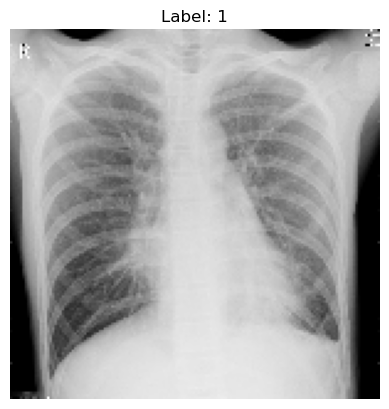

In [113]:
# Vérifier une image
import matplotlib.pyplot as plt

img, label = next(train_generator)
plt.imshow(img[3].astype("uint8"))  # Image RGB brute
plt.title(f"Label: {label[0]}")
plt.axis("off")
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Modèle CNN simple
def create_baseline_model():
    model = Sequential(
        [
            Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),  # RGB
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation="relu"),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation="relu"),
            Dropout(0.5),  # Contre l’overfitting
            Dense(1, activation="sigmoid"),  # Binaire
        ]
    )
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


model = create_baseline_model()
model.summary()

/home/hugo/miniconda3/envs/pneumonie/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1745327101.049393    5122 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745327101.102208    5122 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
EPOCHS = 10
history = model.fit(
    train_generator, epochs=EPOCHS, validation_data=val_generator, verbose=1
)

model.save("baseline_model_2classes_no_preprocessing.h5")

/home/hugo/miniconda3/envs/pneumonie/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - accuracy: 0.7693 - loss: 24.3750 - val_accuracy: 0.8750 - val_loss: 0.3368
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9436 - loss: 0.1651 - val_accuracy: 0.6875 - val_loss: 0.4676
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1378s 9s/step - accuracy: 0.9542 - loss: 0.1256 - val_accuracy: 0.6875 - val_loss: 0.7434
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.9651 - loss: 0.0932 - val_accuracy: 0.8750 - val_loss: 0.4702
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 177ms/step - accuracy: 0.9686 - loss: 0.0828 - val_accuracy: 0.8125 - val_loss: 0.7259
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.9731 - loss: 0.0701 - val_accuracy: 1.0000 - val_loss: 0.1215
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.9796 - loss: 0.0614 - val_accuracy: 0.8750 - val_loss: 0.4251
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.9803 - loss: 0

## **C - Pré-traitement**

Réduisons les dimensions des images et passons les en niveaux de gris.

In [ ]:
import os
import cv2

base_dir = "./data/chest_Xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

def inspect_images(directory):
    sizes = []
    corrupted = []
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.startswith(".") or "Zone.Identifier" in img_name:
                continue
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(
                img_path, cv2.IMREAD_GRAYSCALE
            )  # Charger en niveaux de gris
            if img is None:
                corrupted.append(img_path)
            else:
                sizes.append(img.shape)
    unique_sizes = set(sizes)
    print(f"Directory: {directory}")
    print(f"Nombre d'images chargées: {len(sizes)}")
    print(f"Tailles uniques: {unique_sizes}")
    print(f"Images corrompues: {len(corrupted)}")
    return corrupted


print("Inspection du set d'entraînement:")
corrupted_train = inspect_images(train_dir)
print("\nInspection du set de validation:")
corrupted_val = inspect_images(val_dir)
print("\nInspection du set de test:")
corrupted_test = inspect_images(test_dir)

2025-04-22 12:01:02.327829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 12:01:02.364431: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 12:01:02.687983: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 12:01:02.914926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745316063.102103    5122 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745316063.15

Inspection du set d'entraînement:
Directory: ./data/chest_Xray/train
Nombre d'images chargées: 5216
Tailles uniques: {(1612, 1774), (664, 952), (1396, 1804), (635, 925), (560, 1160), (1515, 1612), (720, 1112), (1048, 1472), (452, 803), (672, 1072), (347, 607), (1206, 1500), (624, 1144), (1672, 1824), (704, 1024), (883, 1255), (1056, 1592), (656, 984), (736, 1056), (849, 1262), (1368, 1678), (947, 1276), (584, 1224), (560, 1016), (2096, 2008), (688, 936), (672, 928), (1044, 1474), (1959, 2268), (616, 1176), (736, 1092), (624, 1000), (1056, 1448), (576, 960), (621, 1111), (1195, 1526), (1088, 1400), (1253, 1733), (632, 1120), (1040, 1360), (712, 1000), (552, 1240), (584, 1080), (1048, 1184), (944, 1472), (1592, 1836), (879, 1406), (560, 872), (536, 1152), (744, 952), (1237, 1608), (1244, 1504), (648, 1064), (1442, 1748), (568, 992), (808, 1202), (1000, 1552), (576, 816), (1145, 1790), (632, 976), (1040, 1216), (1283, 1840), (584, 936), (1558, 1816), (1424, 1736), (1677, 1916), (1743, 209

In [ ]:
import pandas as pd

# DataFrame pour 2 classes
def create_dataframe_2classes(directory):
    file_paths = []
    labels = []
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.startswith(".") or "Zone.Identifier" in img_name:
                continue
            file_paths.append(os.path.join(class_dir, img_name))
            labels.append(0 if class_name == "NORMAL" else 1)  # 0: NORMAL, 1: PNEUMONIA
    return pd.DataFrame({"file_path": file_paths, "label": labels})


# DataFrame pour 3 classes
def create_dataframe_3classes(directory):
    file_paths = []
    labels = []
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.startswith(".") or "Zone.Identifier" in img_name:
                continue
            img_path = os.path.join(class_dir, img_name)
            if class_name == "NORMAL":
                labels.append(0)  
            elif "virus" in img_name.lower():
                labels.append(1)  
            elif "bacteria" in img_name.lower():
                labels.append(2)  
            file_paths.append(img_path)
    return pd.DataFrame({"file_path": file_paths, "label": labels})


train_df_2classes = create_dataframe_2classes(train_dir)
val_df_2classes = create_dataframe_2classes(val_dir)
test_df_2classes = create_dataframe_2classes(test_dir)

train_df_3classes = create_dataframe_3classes(train_dir)
val_df_3classes = create_dataframe_3classes(val_dir)
test_df_3classes = create_dataframe_3classes(test_dir)

print("Répartition 2 classes (train):")
print(train_df_2classes["label"].value_counts())
print("\nRépartition 3 classes (train):")
print(train_df_3classes["label"].value_counts())

Répartition 2 classes (train):
label
1    3875
0    1341
Name: count, dtype: int64

Répartition 3 classes (train):
label
2    2530
1    1345
0    1341
Name: count, dtype: int64


In [93]:
train_df_2classes

,file_path,label
0,./data/chest_Xray/train/NORMAL/NORMAL2-IM-1319...,0
1,./data/chest_Xray/train/NORMAL/NORMAL2-IM-0997...,0
2,./data/chest_Xray/train/NORMAL/NORMAL2-IM-0719...,0
3,./data/chest_Xray/train/NORMAL/NORMAL2-IM-0942...,0
4,./data/chest_Xray/train/NORMAL/NORMAL2-IM-0536...,0
...,...,...
5211,./data/chest_Xray/train/PNEUMONIA/person1160_v...,1
5212,./data/chest_Xray/train/PNEUMONIA/person1593_v...,1
5213,./data/chest_Xray/train/PNEUMONIA/person1609_b...,1
5214,./data/chest_Xray/train/PNEUMONIA/person441_ba...,1


In [99]:
# ## ça à creuser car pas tout compris
# from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

# # Paramètres
# IMG_SIZE = (150, 150)
# BATCH_SIZE = 32

# # Générateurs pour 2 classes
# train_datagen = ImageDataGenerator(
#     rescale=1.0 / 255,  # Normalisation
#     rotation_range=10,  # Augmentation
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     fill_mode="nearest",
# )

# val_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Pas d’augmentation pour val/test

# train_generator_2classes = train_datagen.flow_from_dataframe(
#     train_df_2classes,
#     x_col="file_path",
#     y_col="label",
#     target_size=IMG_SIZE,
#     color_mode="grayscale",
#     batch_size=BATCH_SIZE,
#     class_mode="binary",
#     shuffle=True,
# )

# val_generator_2classes = val_datagen.flow_from_dataframe(
#     val_df_2classes,
#     x_col="file_path",
#     y_col="label",
#     target_size=IMG_SIZE,
#     color_mode="grayscale",
#     batch_size=BATCH_SIZE,
#     class_mode="binary",
#     shuffle=False,
# )

# test_generator_2classes = val_datagen.flow_from_dataframe(
#     test_df_2classes,
#     x_col="file_path",
#     y_col="label",
#     target_size=IMG_SIZE,
#     color_mode="grayscale",
#     batch_size=BATCH_SIZE,
#     class_mode="binary",
#     shuffle=False,
# )

# # Générateurs pour 3 classes
# train_generator_3classes = train_datagen.flow_from_dataframe(
#     train_df_3classes,
#     x_col="file_path",
#     y_col="label",
#     target_size=IMG_SIZE,
#     color_mode="grayscale",
#     batch_size=BATCH_SIZE,
#     class_mode="sparse",  # Pour sparse_categorical_crossentropy
#     shuffle=True,
# )

# val_generator_3classes = val_datagen.flow_from_dataframe(
#     val_df_3classes,
#     x_col="file_path",
#     y_col="label",
#     target_size=IMG_SIZE,
#     color_mode="grayscale",
#     batch_size=BATCH_SIZE,
#     class_mode="sparse",
#     shuffle=False,
# )

# test_generator_3classes = val_datagen.flow_from_dataframe(
#     test_df_3classes,
#     x_col="file_path",
#     y_col="label",
#     target_size=IMG_SIZE,
#     color_mode="grayscale",
#     batch_size=BATCH_SIZE,
#     class_mode="sparse",
#     shuffle=False,
# )

In [95]:
### C - Entrainement du modèle

In [100]:
# import matplotlib.pyplot as plt


# def plot_images(generator, num_images=5):
#     images, labels = next(generator)
#     plt.figure(figsize=(15, 3))
#     for i in range(num_images):
#         plt.subplot(1, num_images, i + 1)
#         plt.imshow(images[i].squeeze(), cmap="gray")
#         plt.title(f"Label: {labels[i]}")
#         plt.axis("off")
#     plt.show()


# plot_images(train_df_2classes)